In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)


In [14]:
print(X)

[[0.22201371 0.54020654]
 [1.34743875 1.41282352]
 [0.53723817 0.37273043]
 ...
 [1.87813003 0.82950037]
 [2.58593336 1.92799501]
 [1.1233558  1.04575545]]


In [15]:
print(y)

[0 0 0 ... 0 0 0]


In [16]:
# summarize class distribution
counter = Counter(y)
print(counter)


Counter({0: 9900, 1: 100})


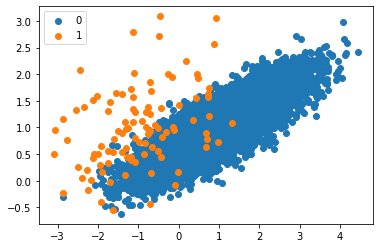

In [17]:
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [18]:
# evaluates a decision tree model on the imbalanced dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


In [20]:
# define model
model = DecisionTreeClassifier()


In [23]:
model

DecisionTreeClassifier()

In [21]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)


In [22]:
cv

RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1)

In [24]:
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)


In [25]:
scores

array([0.7469697 , 0.8969697 , 0.8469697 , 0.74545455, 0.8489899 ,
       0.69747475, 0.7979798 , 0.6989899 , 0.74747475, 0.6969697 ,
       0.7959596 , 0.89747475, 0.6989899 , 0.94646465, 0.7979798 ,
       0.74747475, 0.59848485, 0.74848485, 0.7969697 , 0.6969697 ,
       0.7489899 , 0.74747475, 0.8969697 , 0.89848485, 0.64545455,
       0.64949495, 0.7969697 , 0.6479798 , 0.9479798 , 0.6979798 ])

In [26]:
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.771


In [27]:
import imblearn
print(imblearn.__version__)

0.7.0


### Manually Combine Over- and Undersampling Methods using Pipeline 

In [29]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# define model
model = DecisionTreeClassifier()
# define resampling
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.827


### Manually Combine SMOTE and Random Undersampling

In [31]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# define model
model = DecisionTreeClassifier()
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('m', model)]
pipeline = Pipeline(steps=steps)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.852


### Combination of SMOTE and Tomek Links Undersampling

In [33]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

# define model
model = DecisionTreeClassifier()
# define resampling
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# define pipeline
pipeline = Pipeline(steps=[('r', resample), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.825


### Combination of SMOTE and Edited Nearest Neighbors Undersampling

In [34]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# define model
model = DecisionTreeClassifier()
# define resampling
resample = SMOTEENN()
# define pipeline
pipeline = Pipeline(steps=[('r', resample), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.851
